# Machine Learning Engineering Career Track 
## Step 6: Scale Your Prototype

In this step, your goal is to ensure that your ML/DL approach, which has proved to be viable, can work with large volumes of data. Please work with your mentor to determine what that means for your problem.
Using scikit-learn, SparkML, Keras, TensorFlow, PyTorch or some of the other technologies you have learned, implement your prototype at scale.
In case your earlier prototype was working with a subset, ensure that this scaled-up prototype can handle your complete dataset.
Think about what your capstone problem would look like in the real world:
- How much data would you need to handle?
- Can you scale your prototype to handle that volume of data using the approach and tools you have selected?

Implement the scaled version of your prototype and clearly document the trade-offs and implementation decisions you have to make to be able to scale your algorithm.

## Outline
- in the previous prototype notebook I only ran hyperparameter search on 10% of the data 
- here I will run all the data and perform a longer-running search

In [1]:
from math import ceil, floor
import pickle5 as pickle
import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline 
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (silhouette_score, f1_score, plot_confusion_matrix, 
                             plot_precision_recall_curve, precision_score, recall_score)
from sklearn.preprocessing import QuantileTransformer
from skopt import BayesSearchCV
from skopt.callbacks import TimerCallback, DeadlineStopper
from skopt.space import Real, Categorical, Integer
from tqdm.notebook import tqdm_notebook

In [2]:
checkpoint_path = 'data/features/df.pkl'
with open(checkpoint_path, 'rb') as f:
    df = pickle.load(f)

extract_limit = df.extract_limit.values[0]  # previously found good audio limit
sr = df.sr.values[0] # sample rate

# NB cannot use select_dtypes since features are stored under *int* index *names*
X = df[[c for c in df.columns.values if isinstance(c, int)]] #  + ['audio', 'sr']
y = df.negativity

print('limit ', extract_limit)
print('sr ', sr)
print('X ', X.shape, ' y ', y.shape)

limit  110250
sr  22050.0
X  (13700, 160)  y  (13700,)


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10960, 160), (2740, 160), (10960,), (2740,))

Bring in model and pipeline with hyperparameters established in previous notebook...

In [4]:
def get_model():
    return lgb.LGBMClassifier( 
    	objective='binary', 
    	metric='binary_logloss', 
    	class_weight='balanced', 
    	random_state=0, 
    	n_jobs=-1,
        num_leaves=95,
        n_estimators=320,
        max_depth=14,
        boosting_type='dart',
        learning_rate=0.5,
        min_split_gain=0,
        min_child_weight=1e-05,
        min_child_samples=30,
        subsample=0.97175,
        colsample_bytree=0.95,
        subsample_freq=2,
        reg_alpha=0,
        reg_lambda=0
    )


def get_pipe():
    return Pipeline([
        ('oversampling', ADASYN(random_state=0, n_jobs=-1)), 
        ('standardization', QuantileTransformer(output_distribution='normal', random_state=0)),
        ('decomposition', PCA(n_components=50, random_state=0)),
        ('model', get_model()),
    ])


def bayes_search(X, y, pipe, spaces: dict, n_iter:int, n_points=1, refit=True):
    """Wrapper to simplify hyperparameter experimentation"""
    budget_minutes = 120 # time-based stopping criterion
    cbs = [TimerCallback(), DeadlineStopper(60 * budget_minutes)]
    opt = BayesSearchCV(
        estimator=pipe,
        search_spaces=spaces,
        n_iter=n_iter,
        scoring='f1_weighted',
        n_jobs=-1,
        n_points=n_points,  # number of parameter settings to sample in parallel
        refit=refit,  # after opt, refits on entire dataset, so predictions can be made
        verbose=0,
        cv=3
    )
    res = opt.fit(X, y, callback=cbs)
    iter_times = cbs[0].iter_time
    print(f'elapsed time: {sum(iter_times)/60:.2f}m ave-iter={np.mean(iter_times):.2f}s')
    return res


def plot_spaces(search): 
    score = 'mean_test_score'
    for space in search.search_spaces:        
        plt.scatter(search.cv_results_['param_' + space], search.cv_results_[score])  
        plt.xlabel(space.replace('model__', ''))
        plt.ylabel(score)
        plt.axvline(x=search.best_params_[space], color='orange')
        plt.show();

Run a quick check training on 80% of the data...

In [5]:
pipe = get_pipe()
pipe.fit(X_train, y_train)
train_score = f1_score(y_train, pipe.predict(X_train), average='weighted')
test_score = f1_score(y_test, pipe.predict(X_test), average='weighted')
train_score, test_score

(0.9989963083169126, 0.6058228729479428)

Test perf on 80% of the data is about 0.003 worse (f1) but I had accepted this small amount of loss-of-perf for increased speed.

Now I revisit a hyperparameter search using 80% of the data and setting the search spaces to be centered around the values found using 20% of the data...

In [6]:
spaces = {
    # Power
    'model__num_leaves': Integer(90, 100),                                       # def=31
    'model__n_estimators': Integer(low=300, high=400),                           # def=100    
    'model__max_depth': Integer(10, 28),                                         # def=-1 no limit

    # Learning
    'model__learning_rate': Real(low=0.1, high=0.9, prior='log-uniform'),           # def=0.1
    'model__min_child_weight': Real(low=0.000001, high=0.0001, prior='log-uniform'), # def=1e-3
    'model__min_child_samples': Integer(30, 50),                                    # def=20

    # Bagging
    'model__subsample': Real(0.94, 0.98),                                          # def=1.0
    'model__colsample_bytree': Real(0.92, 0.999),                                   # def=1.0
}

pipe = get_pipe()

ave_iter = 17.26
n_points = 2  # try two parameter sets at a time
minutes = 30
n_iter = int(minutes * 60 * n_points / ave_iter) 

search = bayes_search(X_train, y_train, pipe, spaces, n_iter, n_points, refit=True)

elapsed time: 57.98m ave-iter=33.45s


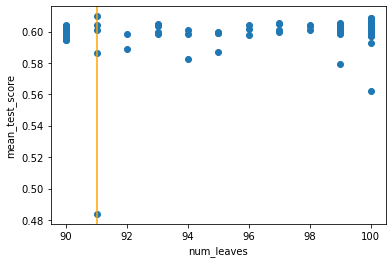

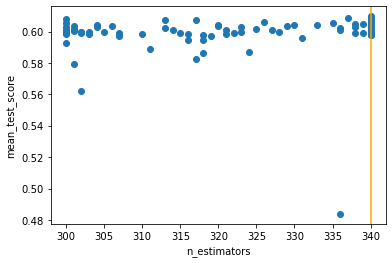

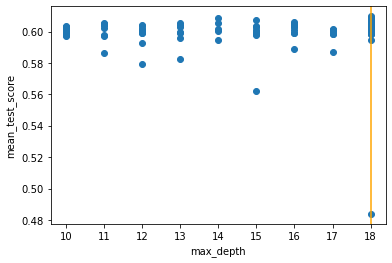

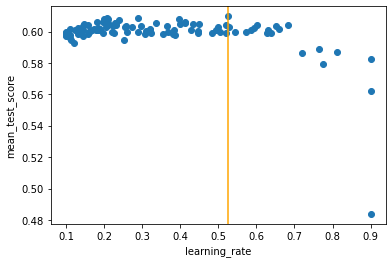

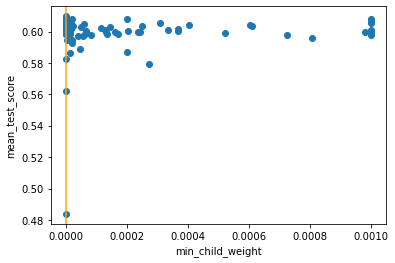

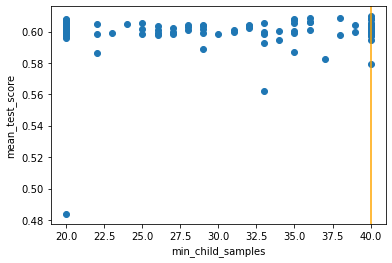

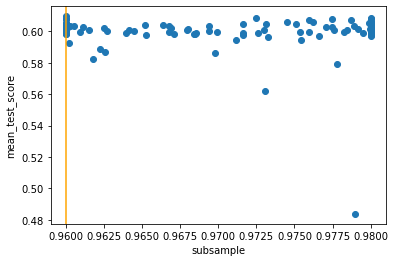

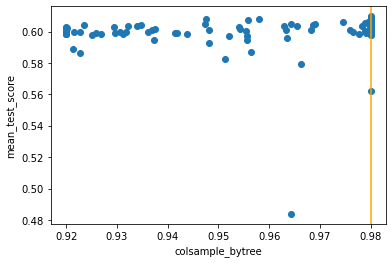

colsample_bytree 0.98
learning_rate 0.5243629214699395
max_depth 18
min_child_samples 40
min_child_weight 1e-06
n_estimators 340
num_leaves 91
subsample 0.96

best cv score= 0.6096859639143979


In [31]:
plot_spaces(search)
for k, v in search.best_params_.items():
    print(k.replace('model__', ''), v)
    
print('\nbest cv score=', search.best_score_)

In [35]:
model = search.best_estimator_
train_score = f1_score(y_train, model.predict(X_train), average='weighted')
test_score = f1_score(y_test, model.predict(X_test), average='weighted')
print('train=', round(train_score, 3), 'test=', round(test_score, 3))

train= 0.999 test= 0.622
